In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [63]:
from datasets import load_dataset
dataset = load_dataset("financial_phrasebank", "sentences_50agree")

df = dataset['train'].to_pandas()

Found cached dataset financial_phrasebank (C:/Users/fabian/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

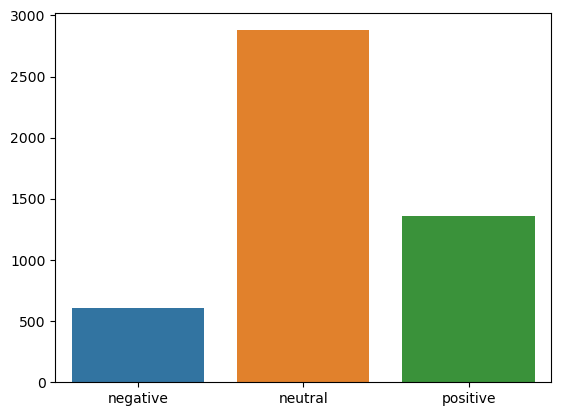

In [64]:
count = df['label'].value_counts()
bar_data = pd.DataFrame({'negative': [count[0]], 'neutral': [count[1]]
        , 'positive': [count[2]]})
sns.barplot(data=bar_data)

# Preprocessing

In [65]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [66]:
# Lemmatize
lemma = WordNetLemmatizer()
stopwords = stopwords.words('english')

def clean_text(text: str) -> list:
    corpus = str(text).lower()
    corpus = re.sub('[^a-zA-Z]+',' ', corpus).strip()
    tokens = word_tokenize(corpus)
    words = [i for i in tokens if i not in stopwords]
    lemmatize = [lemma.lemmatize(w) for w in words]

    return lemmatize

preprocess_text = [clean_text(i) for i in df['sentence']]
df['preprocess_text'] = preprocess_text

# Method 1 Positive and Negative Word Count with Normalization

In [67]:
# Importing list of positive and negative words
with open('positive-words.txt', 'r') as file1:
    pos_words = file1.read()

with open('negative-words.txt', 'r') as file2:
    neg_words = file2.read()

pos_words = [i for i in pos_words.split('\n')]
neg_words = [i for i in neg_words.split('\n')]

count_pos = df['preprocess_text'].map(lambda x: len([i for i in x if i in pos_words]))
count_neg = df['preprocess_text'].map(lambda x: len([i for i in x if i in neg_words]))

df['count_pos'] = count_pos
df['count_neg'] = count_neg

df['total_len'] = df['preprocess_text'].map(lambda x: len(x))

df['sentiment_score'] = round((df['count_pos'] - df['count_neg']) /df['total_len'], 2)


In [68]:
'''
Let's test the accuracy of the sentiment score
We set an arbitrary classification rule of the following:

sentiment_score < -threshold     ---> Negative
-threshold<=sentiment_score<=threshold ---> Neutral
sentiment_score > threshold     ---> Positive

with the threshold being a value we can set.
'''

def score_classification(score, threshold):
    if score < -threshold:
        res = 0
    elif score <= threshold:
        res = 1
    else:
        res = 2
    
    return res

thresholds = [0.01, 0.02, 0.05, 0.10, 0.2, 0.5, 0.75, 1] # list of threshold values we can test

for threshold in thresholds:
    df['sentiment_score {}'.format(threshold)] = df['sentiment_score'].map(lambda x: score_classification(x, threshold))
    result = df.apply(lambda x: 1 if x['sentiment_score {}'.format(threshold)] == x['label'] else 0, axis=1).sum()
    df.drop(['sentiment_score {}'.format(threshold)], axis=1)
    accuracy = result / len(df) * 100
    print("The overall accuracy with a threshold of {} is {:.2f}%".format(threshold, accuracy))


The overall accuracy with a threshold of 0.01 is 54.91%
The overall accuracy with a threshold of 0.02 is 54.91%
The overall accuracy with a threshold of 0.05 is 55.28%
The overall accuracy with a threshold of 0.1 is 57.94%
The overall accuracy with a threshold of 0.2 is 59.33%
The overall accuracy with a threshold of 0.5 is 59.29%
The overall accuracy with a threshold of 0.75 is 59.33%
The overall accuracy with a threshold of 1 is 59.39%


## Method 2 VADER SentimentIntensityAnalyser

In [69]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [70]:
sent = SentimentIntensityAnalyzer()

polarity = [round(sent.polarity_scores(t)['compound'], 2) for t in df['sentence']]
df['sentiment_score (VADER)'] = polarity

In [71]:
# Using the same rule of classification as before
for threshold in thresholds:
    df['sentiment_score (VADER) {}'.format(threshold)] = df['sentiment_score (VADER)'].map(lambda x: score_classification(x, threshold))
    result = df.apply(lambda x: 1 if x['sentiment_score (VADER) {}'.format(threshold)] == x['label'] else 0, axis=1).sum()
    df.drop(['sentiment_score {}'.format(threshold)], axis=1)
    accuracy = result / len(df) * 100
    print("The overall accuracy (VADER) with a threshold of {} is {:.2f}%".format(threshold, accuracy))


The overall accuracy (VADER) with a threshold of 0.01 is 54.27%
The overall accuracy (VADER) with a threshold of 0.02 is 54.25%
The overall accuracy (VADER) with a threshold of 0.05 is 54.44%
The overall accuracy (VADER) with a threshold of 0.1 is 54.97%
The overall accuracy (VADER) with a threshold of 0.2 is 55.43%
The overall accuracy (VADER) with a threshold of 0.5 is 61.33%
The overall accuracy (VADER) with a threshold of 0.75 is 59.68%
The overall accuracy (VADER) with a threshold of 1 is 59.41%


## Method 3 Using TF-IDF and Scikit-Learn classifiers

In [72]:
# We need to pre process text in a different way for this method
combine_words = lambda word_list: ' '.join(word_list)
df['preprocess_text'] = df['preprocess_text'].apply

In [73]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['preprocess_text'], df['label'], test_size=0.25, random_state=42)

print("Train: {}, Test: {}".format((X_train.shape, y_train.shape), (X_test.shape, y_test.shape)))
X_train

Train: ((3634,), (3634,)), Test: ((1212,), (1212,))


4229    <bound method Series.apply of 0       [accordi...
2598    <bound method Series.apply of 0       [accordi...
4524    <bound method Series.apply of 0       [accordi...
1161    <bound method Series.apply of 0       [accordi...
1873    <bound method Series.apply of 0       [accordi...
                              ...                        
4426    <bound method Series.apply of 0       [accordi...
466     <bound method Series.apply of 0       [accordi...
3092    <bound method Series.apply of 0       [accordi...
3772    <bound method Series.apply of 0       [accordi...
860     <bound method Series.apply of 0       [accordi...
Name: preprocess_text, Length: 3634, dtype: object

In [74]:
# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Metrics
from sklearn.metrics import classification_report

tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

AttributeError: 'function' object has no attribute 'lower'

In [ ]:
# SVM
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=0)

svm.fit(tf_x_train, y_train)
y_test_pred = svm.predict(tf_x_test)

report = classification_report(y_test, y_test_pred, output_dict=True)
report

c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'0': {'precision': 0.7129629629629629,
  'recall': 0.5384615384615384,
  'f1-score': 0.6135458167330677,
  'support': 143.0},
 '1': {'precision': 0.7610837438423645,
  'recall': 0.8667601683029453,
  'f1-score': 0.8104918032786885,
  'support': 713.0},
 '2': {'precision': 0.6712328767123288,
  'recall': 0.550561797752809,
  'f1-score': 0.6049382716049383,
  'support': 356.0},
 'accuracy': 0.7351485148514851,
 'macro avg': {'precision': 0.7150931945058855,
  'recall': 0.6519278348390977,
  'f1-score': 0.6763252972055649,
  'support': 1212.0},
 'weighted avg': {'precision': 0.729014288096451,
  'recall': 0.7351485148514851,
  'f1-score': 0.7268776668497455,
  'support': 1212.0}}

In [ ]:
# Let's try to optimize the hyperparameters using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]
              , "kernel": ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, error_score='raise')
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


ValueError: could not convert string to float: 'metso said order worth around mln eur supply kraftliner board machine china lee man paper co'